In [1]:
suppressPackageStartupMessages({
    library(dplyr)
    library(reshape2)
    library(tibble)
    library(gplots)
    library(stringr)
    library(ggplot2)
    library(RColorBrewer)
    library(ggpubr)
})

theme_set(theme_minimal())
theme_update(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
theme_update(text = element_text(size = 17))

#Functions

get_genus <- function(taxon_string){
    if(taxon_string == "") {
        ret = NA } else {
    bacs = str_split(taxon_string, ",")[[1]]
    ret = unlist(unique(lapply(str_split(bacs,"/"),`[[`, 5)))[1]
    if(grepl("acteroides", ret, fixed=TRUE)) ret = "Bacteroides_mix"
        }
    return (ret)
    }

get_phylum <- function(taxon_string){
    if(taxon_string == "") {
        ret = NA } 
    else {
        bacs = str_split(taxon_string, ",")[[1]]
        ret = unlist(unique(lapply(str_split(bacs,"/"),`[[`, 1)))[1]}
    return (ret)
    }

my_hm_funtion = function(annotate_phage, annotate_sample, lib, value_var, max_vals = 5) {
    options(repr.plot.width=29, repr.plot.height=17)
    hmcol = colorRampPalette(brewer.pal(9, "BrBG"))(100)
    phar %>% subset(library == lib) %>% 
    arrange(GPD_VC) %>% mutate(taxon_id = paste(taxon_id,GPD_VC)) %>%
    mutate(taxon_id = factor(taxon_id, levels = unique(taxon_id))) -> hm_df
    hm_df %>% select(sample, one_of(annotate_sample)) %>% distinct() %>% column_to_rownames("sample") -> moi
    hm_df %>% select(taxon_id, one_of(annotate_phage)) %>% distinct() %>% column_to_rownames("taxon_id") -> pmoi
    hm_df %>% dcast(sample ~ taxon_id, value.var=value_var) %>% 
    column_to_rownames("sample") %>% as.matrix() %>%
    heatmap.2(dendrogram ="none", trace="none",Rowv = TRUE, Colv = TRUE,
            scale= "none", hclustfun=function(c){hclust(c, method="mcquitty")},
             lmat = rbind(c(0,5,0),c(0,2,0),c(1,3,4),c(0,6,0)), lwid = c(0.1,4,1), lhei = c(0.1,0.1,2,0.4), margins=c(15,5), # layout sizes
             key.title =NA, symkey = FALSE, key=TRUE, col=hmcol, breaks = seq(-max_vals, max_vals, length.out = 101), cexRow = 2 , cexCol = 1,
             RowSideColors=moi[rownames(.),], ColSideColors=pmoi[colnames(.),]                                   
    )
    legend(y=0.1, x=0.85,legend = unique(moi[,annotate_sample]), col = unique(as.numeric(moi[,annotate_sample])), lty= 1,lwd = 8, cex=1)
    legend(y=0.9, x=0.9,legend = unique(pmoi[,annotate_phage]), col = unique(as.numeric(pmoi[,annotate_phage])), lty= 1,lwd = 8, cex=1)
    }

manyplots = function(data_to_plot, cols_of_interest){
    plots = lapply(cols_of_interest, function(col){ 
        gg = ggplot(data= data_to_plot) + geom_point(aes(x=x, y=y, color=!!sym(col)), size = 2) + xlab("") + ylab("") + theme(legend.position = "bottom") 
        if ((class(data_to_plot[,col]) == "numeric") | (class(data_to_plot[,col]) == "integer"))
            gg = gg + scale_color_gradient(low = "lightblue", high = "black")
        else
            gg = gg + scale_color_discrete(na.value="lightgrey") + guides(colour = guide_legend(title.position = "top", nrow = 5))
        return(gg)
    })
    return(plots) }

my_pca_function = function(cols_of_interest,lib,plots_horizontal, score, switch_phages, plotwid, plothei){
    options(repr.plot.width=plotwid, repr.plot.height=plothei)   
    based_on = "sample"
    not_based_on = "taxon_id"
    title_piece = "of Phages"
    if(switch_phages){
        based_on="taxon_id"
        not_based_on ="sample"
        title_piece = "of Samples based on Phages"
    }    
    phar %>% subset(library == lib)  %>% 
    select(all_of(cols_of_interest), taxon_id, one_of(score), sample) %>%
    tidyr::spread(based_on,score) -> pca_df
    pca_df %>% select(-all_of(cols_of_interest), -one_of(not_based_on)) %>% select(which(!colSums(., na.rm=TRUE) %in% 0)) %>% prcomp(center=TRUE, scale. = TRUE) -> pca 
    title= paste(lib, "PCA",title_piece,"- PC1:",round(100*summary(pca)$importance[2,1], 2), "%, PC2:", round(100*summary(pca)$importance[2,2], 2), "%")
    cbind(data.frame(x = pca$x[,1], y = pca$x[,2]), pca_df %>% select(all_of(cols_of_interest))) %>% manyplots(cols_of_interest) %>%
    cowplot::plot_grid(plotlist = ., ncol = plots_horizontal, align = "h", labels = title)    
}

In [2]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.4 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggpubr_0.4.0       RColorBrewer_1.1-3 ggplot2_3.3.6      stringr_1.4.0     
[5] gplots_3.1.3       tibble_3.1.8       reshape2_1.4.4     dplyr_1.0.9       

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.9         pillar_1.8.0       compiler_3.6.3     plyr_1.8.7        
 [5] base64enc_0.1-3    bitops_1.0-7     

In [3]:
# combine all phage annotation data
GPD_anno = read.table("../data/GPD_annotation_pilotphages.csv", sep = ",", header=TRUE, comment.char = "", row.names = 1)
GPD_anno %>% mutate(NorthAmcaFreq = str_count(Continents_detected, "North America")) %>% 
select(Source, GPD_VC, Size, Predicted_phage_taxon, checkV_prophage, Novel, NorthAmcaFreq, Host_range_taxon) %>% rownames_to_column("taxon_id") -> GPD_anno

GPD_anno %>% select(taxon_id,GPD_VC) %>% unique() %>%
select(GPD_VC) %>% table() %>% as.data.frame() %>% rename(GPD_VC = ".") %>% 
rename(cluster_phages = "Freq") %>% subset(cluster_phages==1) %>% pull(GPD_VC) -> singleclusters

GPD_anno %>% mutate(GPD_VC = ifelse(GPD_VC %in% singleclusters, NA, GPD_VC)) %>%
mutate(GPD_VC = as.factor(GPD_VC)) %>%
mutate(Host_Genus = sapply(Host_range_taxon,get_genus)) %>% mutate(Host_Genus = as.factor(Host_Genus)) %>%
mutate(Host_Phylum = sapply(Host_range_taxon,get_phylum)) %>% mutate(Host_Phylum = as.factor(Host_Phylum)) %>%
mutate(Predicted_phage_taxon = droplevels(Predicted_phage_taxon,"")) %>% 
mutate(bin_myoviridae = as.factor(ifelse(Predicted_phage_taxon %in% "Myoviridae", "True", "False"))) %>%
mutate(bin_Escherichia = as.factor(ifelse(Host_Genus %in% "Escherichia", "True", "False")))  -> 
GPD_anno

blast_anno = read.table("../data/pilotphages_blast_annotation.csv", sep = ",", header=TRUE, row.names = 1) 
paste("Blast", colnames(blast_anno), sep = "_") -> colnames(blast_anno)
blast_anno %>% rownames_to_column("taxon_id") %>% merge(GPD_anno) -> GPD_anno

phage_meta = GPD_anno

In [4]:
anno_pep = read.table("../data/PhageScan_PeptideAnno.tsv", header = TRUE, sep = "\t", stringsAsFactors=FALSE)
anno_pep %>% 
    select(c("sublibrary","pro_id", "pep_id", "taxon_id", "pro_id_all")) -> anno_pep

anno_pep %>% select(pep_id,pro_id_all) %>% distinct() %>% 
    mutate(pro_id_all = gsub("[{} ]","",pro_id_all)) %>%
    mutate(pro_id_all = strsplit(pro_id_all,",")) -> peptide_clusters_map
p = peptide_clusters_map$pro_id_all
names(p) <- peptide_clusters_map$pep_id
stack(p) %>% mutate(values = gsub("'","",values)) -> protein_clusters
anno_pep %>% merge(protein_clusters, by.x = 'pep_id', by.y = "ind", all = TRUE) %>% 
    rename(pro_id_representative = pro_id) %>% rename(pro_id = values) %>% select(-pro_id_all) -> anno_pep
anno_pep %>% select(-taxon_id) %>%  mutate(taxon_id = sub("_[^_]+$", "", pro_id)) %>% 
rename(library = sublibrary) -> anno_pep

anno_pep %>% 
distinct(taxon_id, library) %>%
merge(GPD_anno) -> phage_meta 

In [5]:
meta = read.table("../data/PhageScan_sampleAnnotation.csv", sep = ",")
phar = read.table("../data/PhARscores_dolphyn_pepsyn.csv", sep = ",", header = TRUE, stringsAsFactors=FALSE)

phar %>% mutate(vir_score_bin = ifelse(vir_score > 1, 1, 0))  -> phar

#clusters defined with heatmap clustering: hclustfun=function(c){hclust(c, method="mcquitty")} and dendrogram

phage_cluster_1 = c('uvig_357441','uvig_578696','uvig_449019','uvig_359760','uvig_357645','uvig_359554','uvig_80910','uvig_577448','uvig_577424','uvig_558569','uvig_552393','uvig_542782','uvig_535970','uvig_533353','uvig_529959','uvig_525990','uvig_512665','uvig_509342','uvig_506411','uvig_505586','uvig_453526','uvig_453409','uvig_430938','uvig_396758','uvig_396640','uvig_395437','uvig_379702','uvig_375837','uvig_372157','uvig_361191','uvig_359377','uvig_359217','uvig_359155','uvig_358852','uvig_358682','uvig_358476','uvig_358303','uvig_356955','uvig_356912','uvig_356792','uvig_356577','uvig_356526','uvig_356500','uvig_356375','uvig_356259','uvig_356033','uvig_355947','uvig_355854','uvig_355478','uvig_355286','uvig_354826','uvig_354750','uvig_307260','uvig_304445','uvig_295951','uvig_29025','uvig_272223','uvig_271818','uvig_267525','uvig_225655','uvig_213404','uvig_211095','uvig_193528','uvig_160801','uvig_158613','ivig_464','ivig_4176','ivig_3679','ivig_3875','uvig_357534','uvig_357814')
phage_cluster_2 = c('uvig_357864','uvig_356969','uvig_355218','uvig_354716','uvig_355148')
phage_cluster_3 = c('uvig_354753','uvig_428798','ivig_402','uvig_418132','ivig_896','ivig_3353','ivig_2749','ivig_2899','uvig_409788','uvig_297199','ivig_601','ivig_1166','ivig_2154')
phage_cluster_4 = c('uvig_356750','uvig_358797','uvig_395307','ivig_2643','ivig_2475','uvig_429694','uvig_354790','uvig_315082','uvig_429042','uvig_359213','uvig_578788','ivig_4424','uvig_357328','uvig_359660','uvig_379414','uvig_385029','uvig_356226','ivig_4427','uvig_315372','ivig_1427','uvig_396772','uvig_205260','uvig_250342')

sample_cluster_1 = c('SO.0665.01X194','SO.0761.01X194','S3.0078.01X194','S3.0154.01X195','S3.0137.01X195','S3.0652.01X195','SO.0437.01X194','SO.0491.01X194','S3.0616.01X194','S3.0586.01X195','S3.0500.01X195','S3.0153.01X194','S3.0631.01X195','SO.0479.01X195','S3.0630.01X195','S3.0693.01X195','SO.0749.01X194','S3.0698.01X194','S3.0701.01.2X194','S3.0693.01.2X194','S3.0662.01X195')
sample_cluster_2 = c('S3.0657.01X194','S3.0633.01X194','S3.0720.01X195','S3.0665.01X194','S3.0171.01X194','S3.0701.01X194','S3.0736.01X195','S3.0521.01X195','S3.0748.01X194','SO.0739.01X194','SO.0458.01X194','SO.0386.01X194','S3.0598.01X195','S3.0710.01X194','S3.0613.01X195')
sample_cluster_3 = c('SO.0456.01X195','SO.0679.02X194','S3.0719.01X195','S3.0149.01X195','S3.0800.01X194','S3.0617.01X194','S3.0700.01X194','S3.0144.01X194','S3.0646.01X194','S3.0639.01X195','SO.0746.01X194','S3.0677.01X194','S3.0906.01X194','S3.0495.01X194','S3.0723.01X195','S3.0169.01X194','S3.0195.01X194')

sample_clusters = rbind(data.frame(sample = sample_cluster_1, sample_cluster = "SC_1"), data.frame(sample = sample_cluster_2, sample_cluster = "SC_2"), data.frame(sample = sample_cluster_3, sample_cluster = "SC_3"))
phage_clusters = rbind(data.frame(taxon_id = phage_cluster_1, phage_cluster = "PC_1"),data.frame(taxon_id = phage_cluster_2, phage_cluster = "PC_2"),data.frame(taxon_id = phage_cluster_3, phage_cluster = "PC_3"),data.frame(taxon_id = phage_cluster_4, phage_cluster = "PC_4"))

phar %>% merge(meta, all.x = TRUE) %>% merge(phage_meta, all.x = TRUE) %>% 
merge(sample_clusters) %>% 
merge(phage_clusters) -> phar

In [6]:
names(phar)

[1] "taxon_id"               "sample"                 "library"               
 [4] "sample_id"              "total_peps"             "score"                 
 [7] "score_norm"             "shape"                  "rate"                  
[10] "mean"                   "variance"               "vir_score"             
[13] "virus_fc"               "p_val"                  "plate"                 
[16] "p_val_re"               "vir_score_bin"          "Age"                   
[19] "Sex"                    "Race"                   "Blast_Escherichia.coli"
[22] "Blast_Blautia"          "Blast_Bacteroides"      "Blast_Bacteriophage"   
[25] "Blast_Siphoviridae"     "Blast_Myoviridae"       "Blast_Podoviridae"     
[28] "Source"                 "GPD_VC"                 "Size"                  
[31] "Predicted_phage_taxon"  "checkV_prophage"        "Novel"                 
[34] "NorthAmcaFreq"          "Host_range_taxon"       "Host_Genus"            
[37] "Host_Phylum"            "bin_myoviridae"         "bin_Escherichia"       
[40] "sample_cluster"         "phage_cluster"

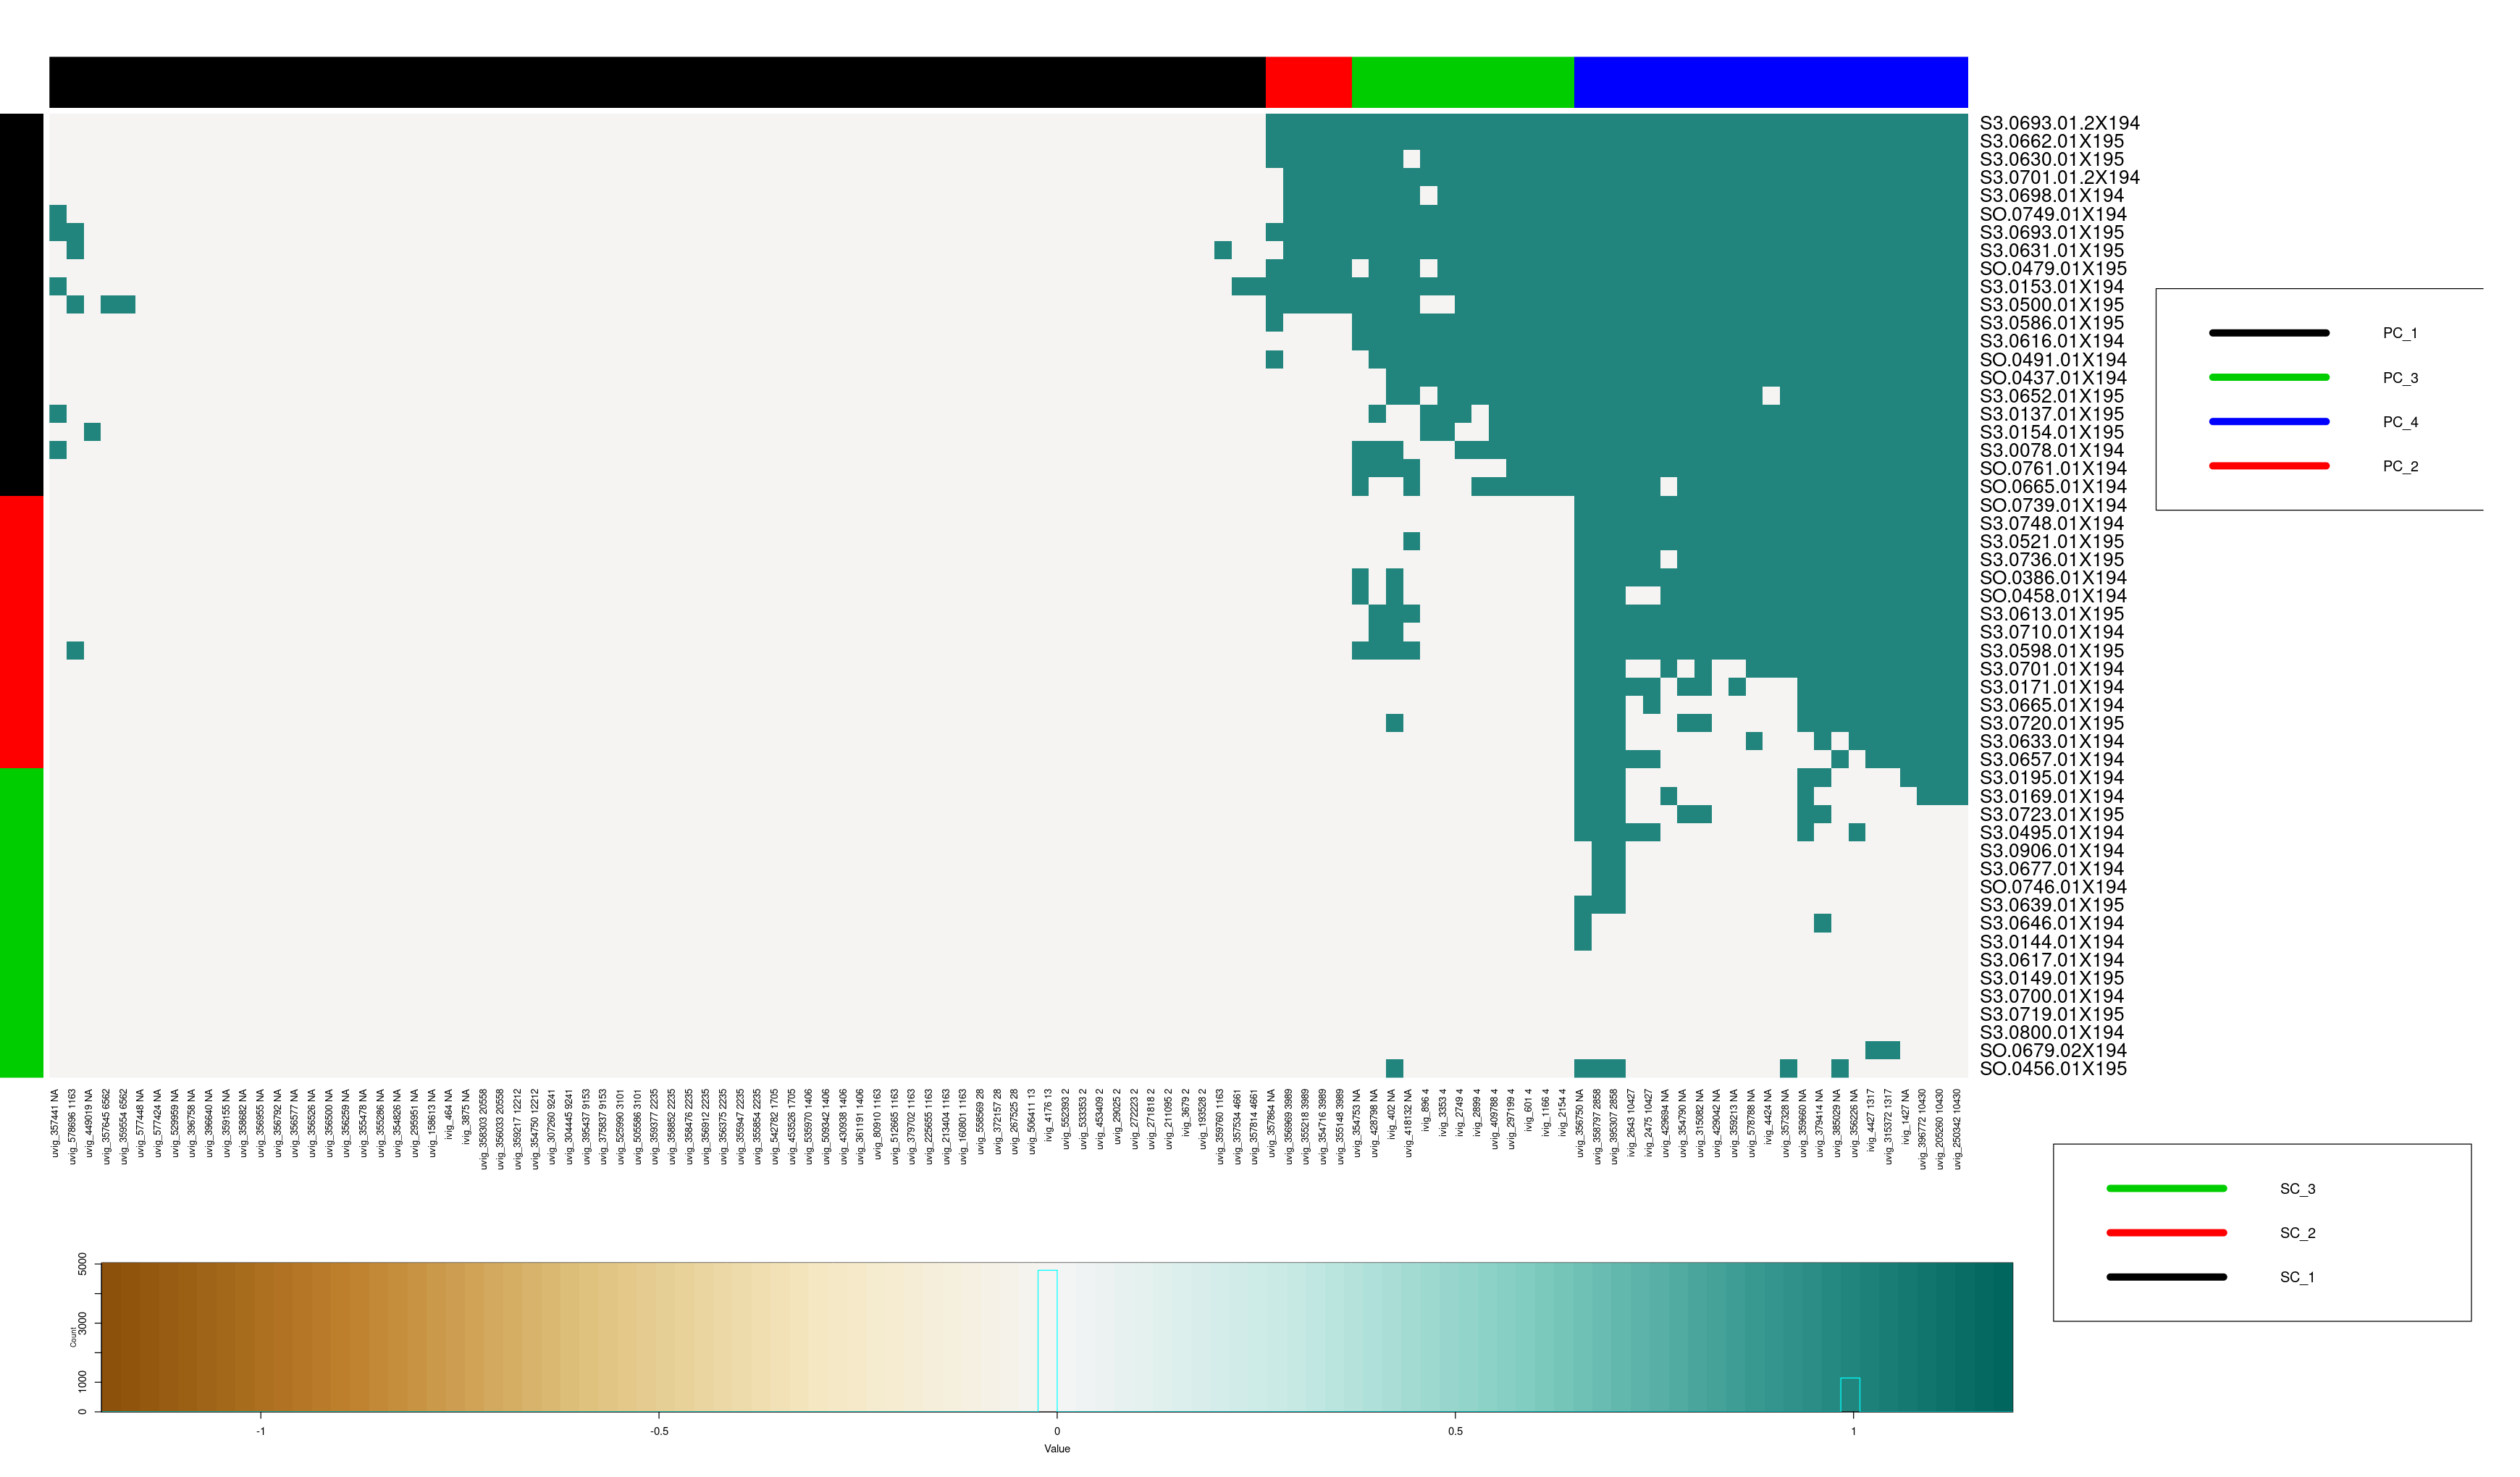

In [7]:
my_hm_funtion("phage_cluster","sample_cluster","pepsyn","vir_score_bin", max_vals = 1.2)

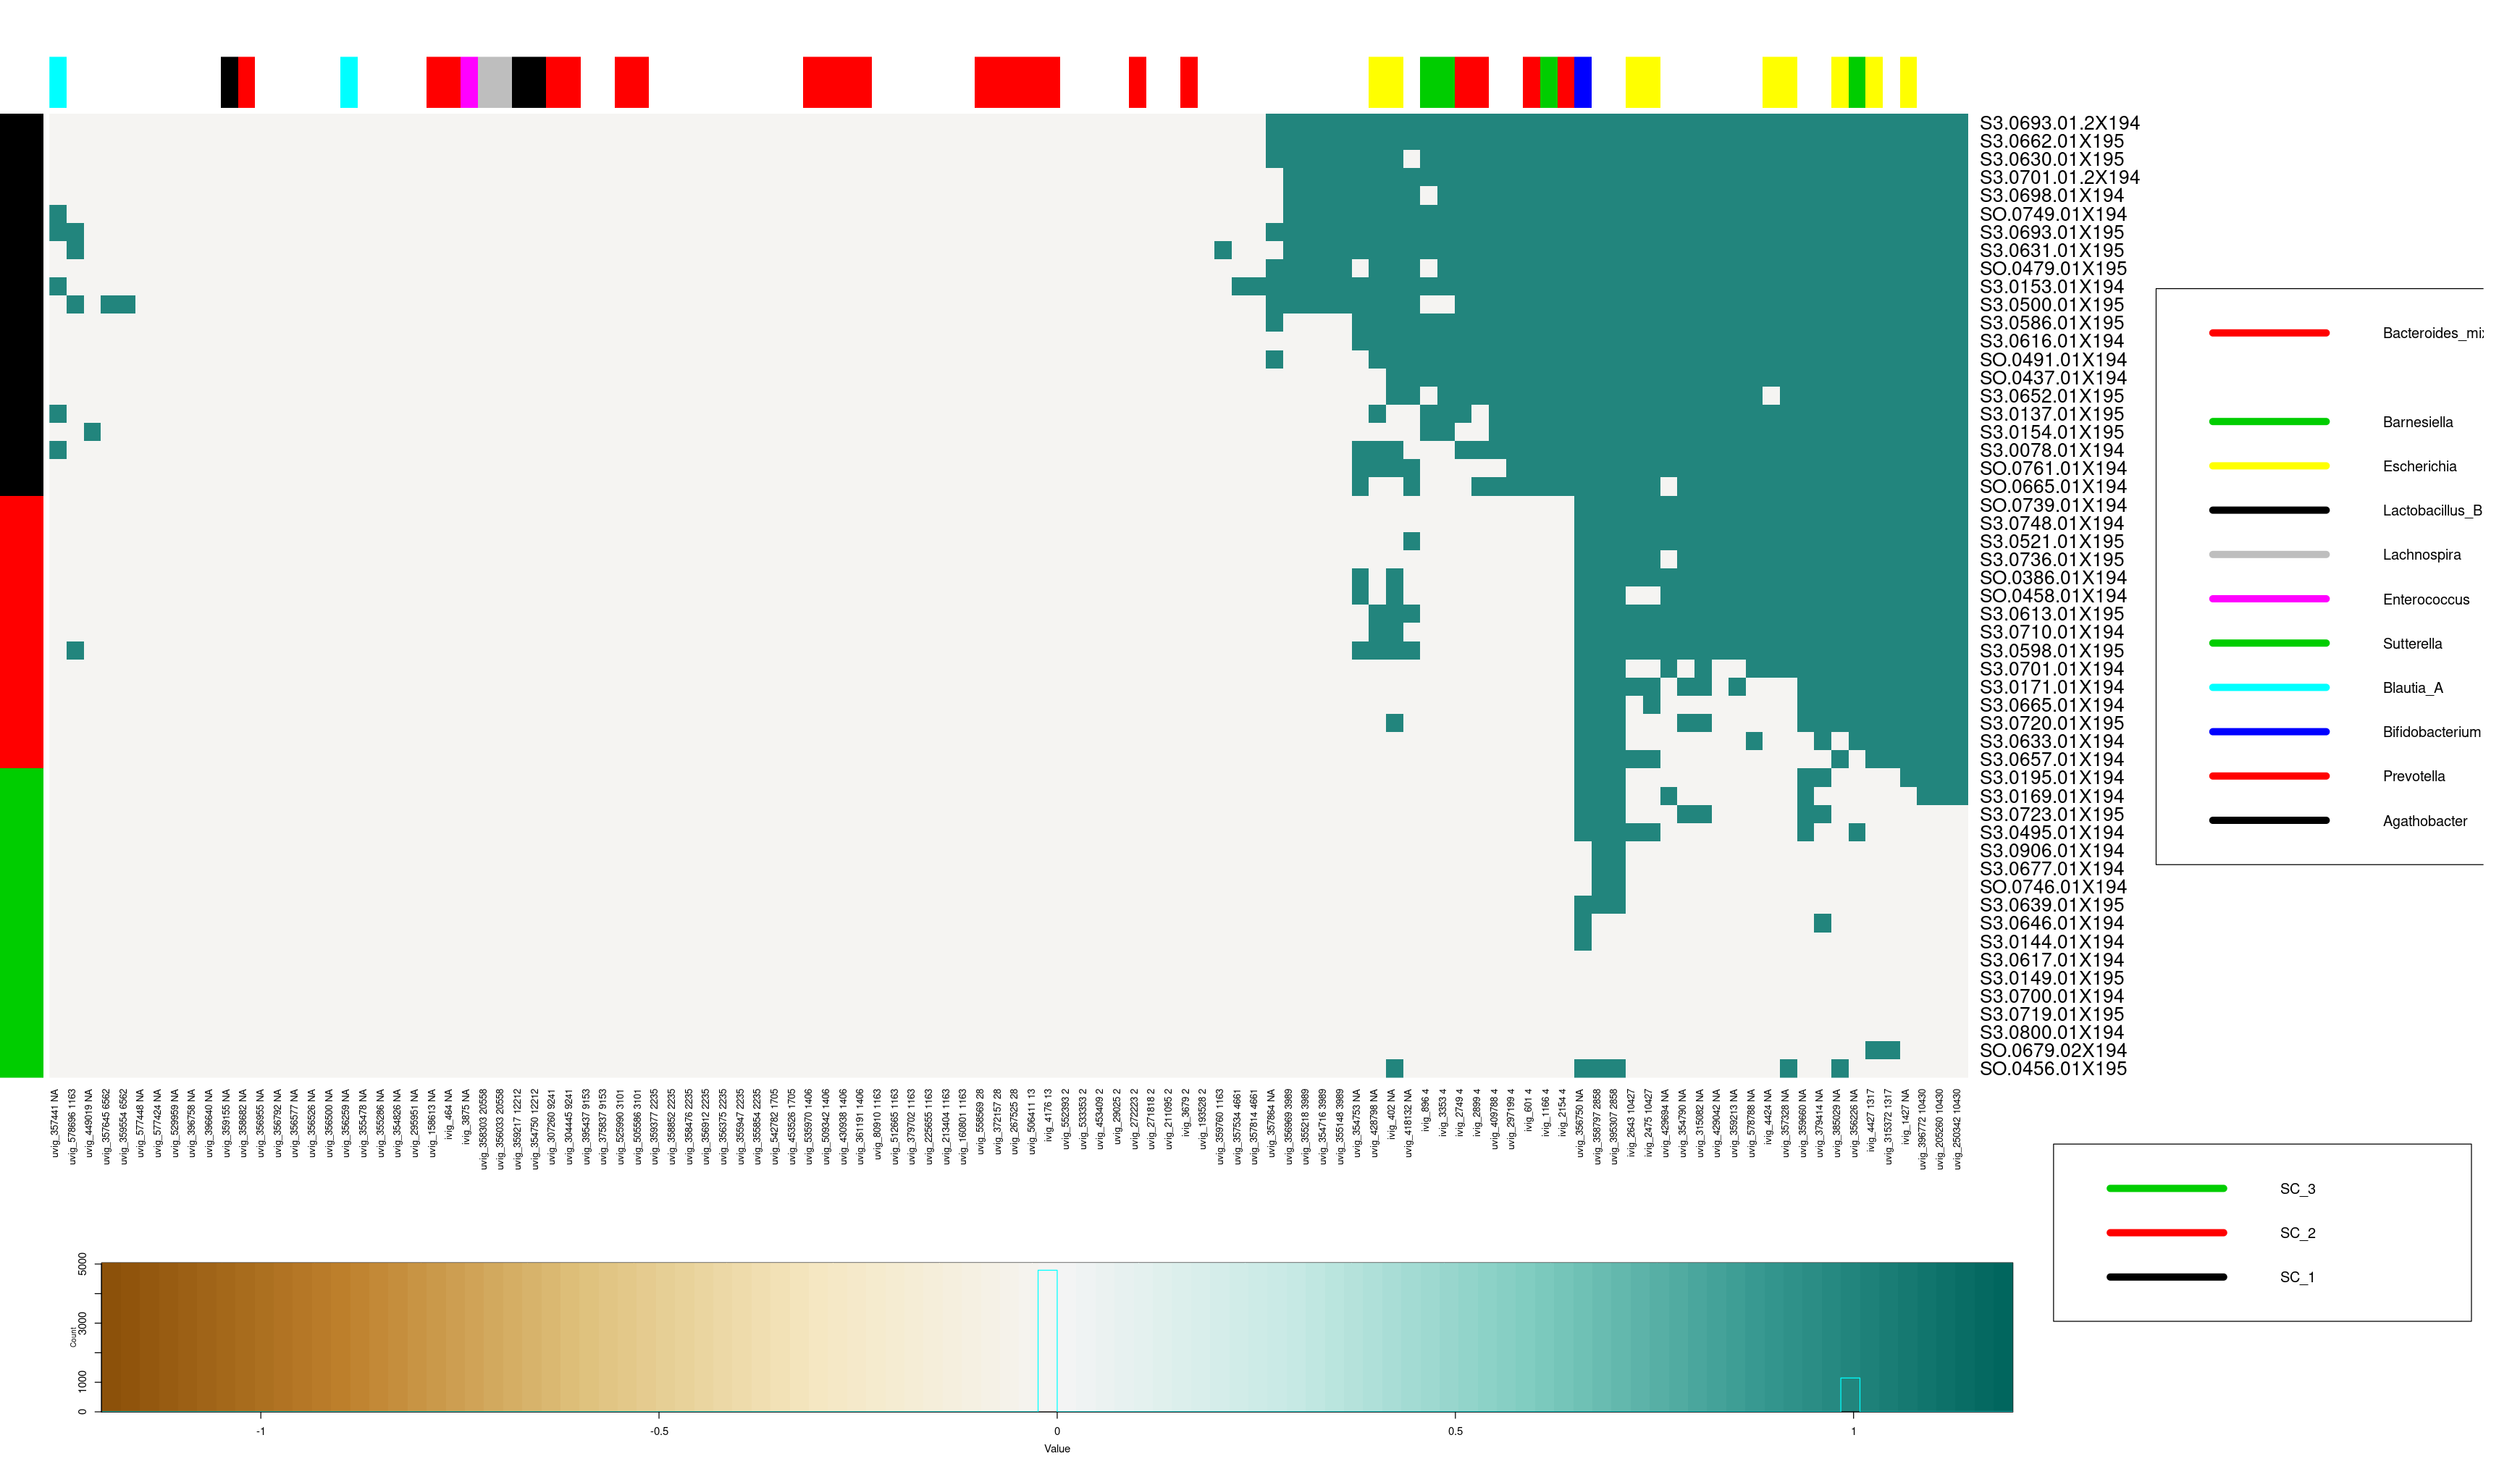

In [8]:
my_hm_funtion("Host_Genus","sample_cluster","pepsyn","vir_score_bin", max_vals = 1.2)

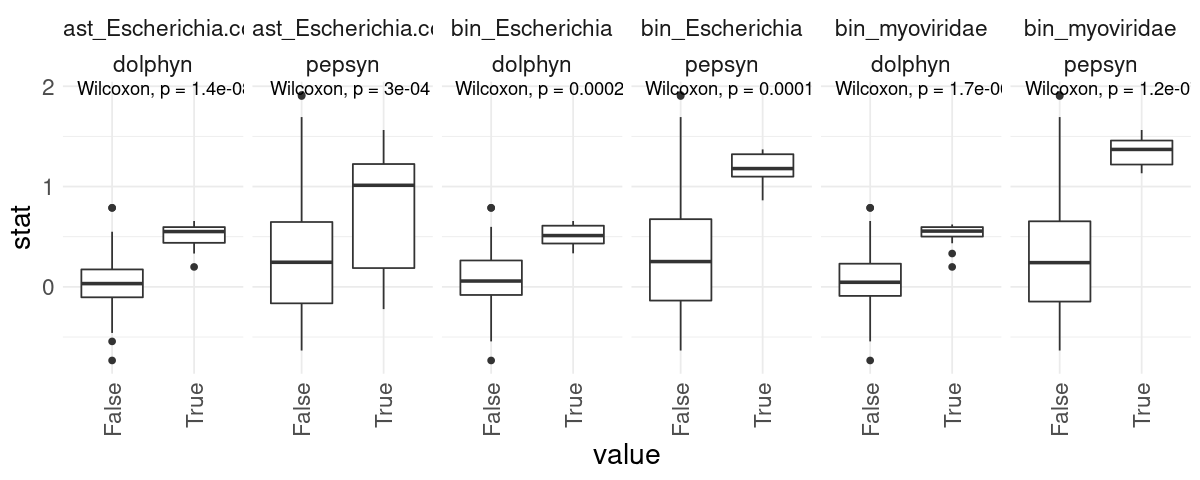

In [9]:
options(repr.plot.width=10, repr.plot.height=4)

phar %>% select(taxon_id, Blast_Escherichia.coli, bin_Escherichia, bin_myoviridae, sample, vir_score, library) %>% 
group_by(library, taxon_id, Blast_Escherichia.coli, bin_Escherichia, bin_myoviridae) %>% 
summarise_at(vars(vir_score),list(stat=mean)) %>%
melt(id.vars=c("taxon_id","stat","library"), variable.name="property") %>%
ggplot(aes(value,stat)) + geom_boxplot() + stat_compare_means()  + facet_grid(~property+library)

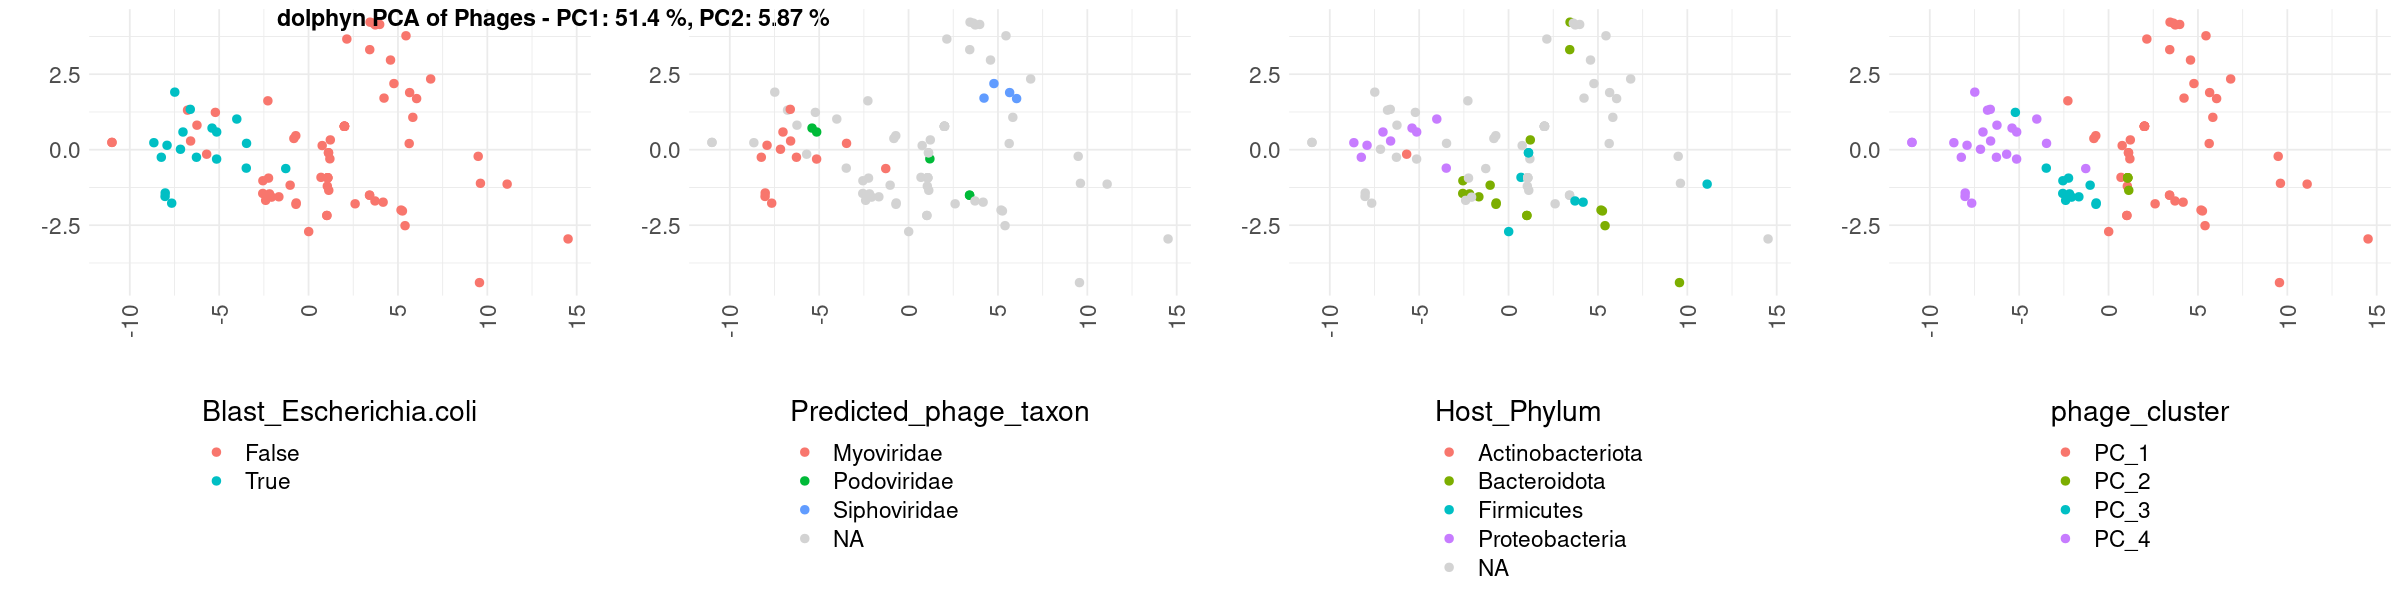

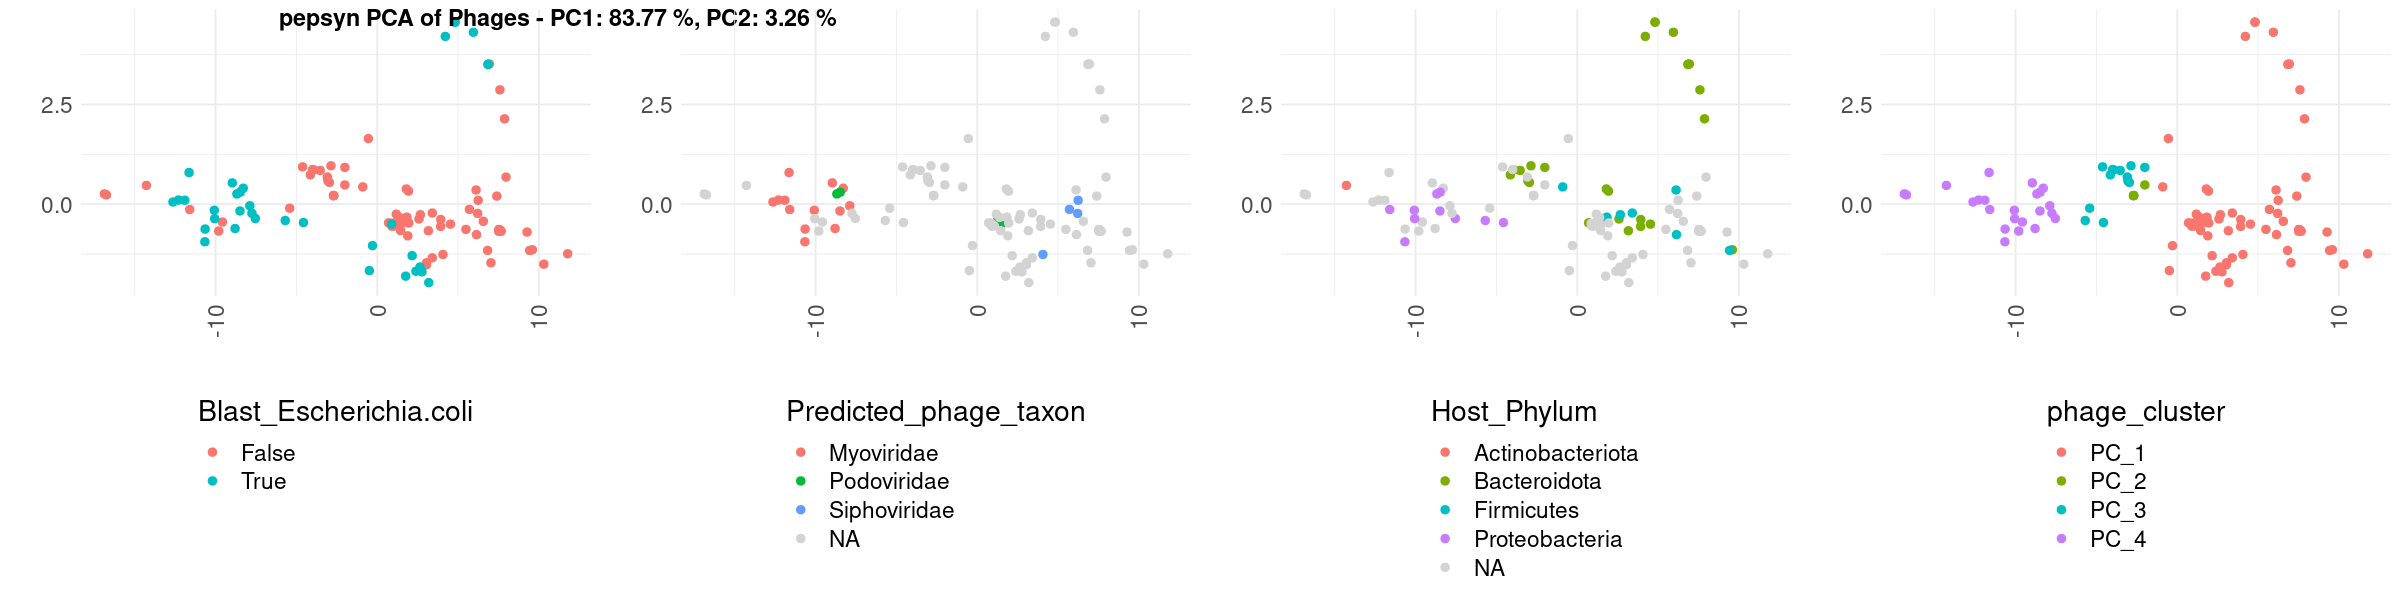

In [10]:
cols_of_interest = c(names(blast_anno),"total_peps","NorthAmcaFreq","Source","GPD_VC","Size","Predicted_phage_taxon","Host_Phylum","Host_Genus","checkV_prophage","Novel","prot_per_phage","peps_per_phage","phage_len","phage_cluster")
cols_of_interest = c("Blast_Bacteriophage","Blast_Escherichia.coli","NorthAmcaFreq","GPD_VC","Size","Predicted_phage_taxon","Host_Phylum","phage_cluster")
cols_of_interest = c("Blast_Escherichia.coli","Predicted_phage_taxon","Host_Phylum","phage_cluster")
score = "vir_score"
plots_horizontal = 4

my_pca_function(cols_of_interest, "dolphyn", plots_horizontal, score, switch_phages = FALSE, plotwid=20, plothei=5)
my_pca_function(cols_of_interest, "pepsyn", plots_horizontal, score, switch_phages = FALSE, plotwid=20, plothei=5)

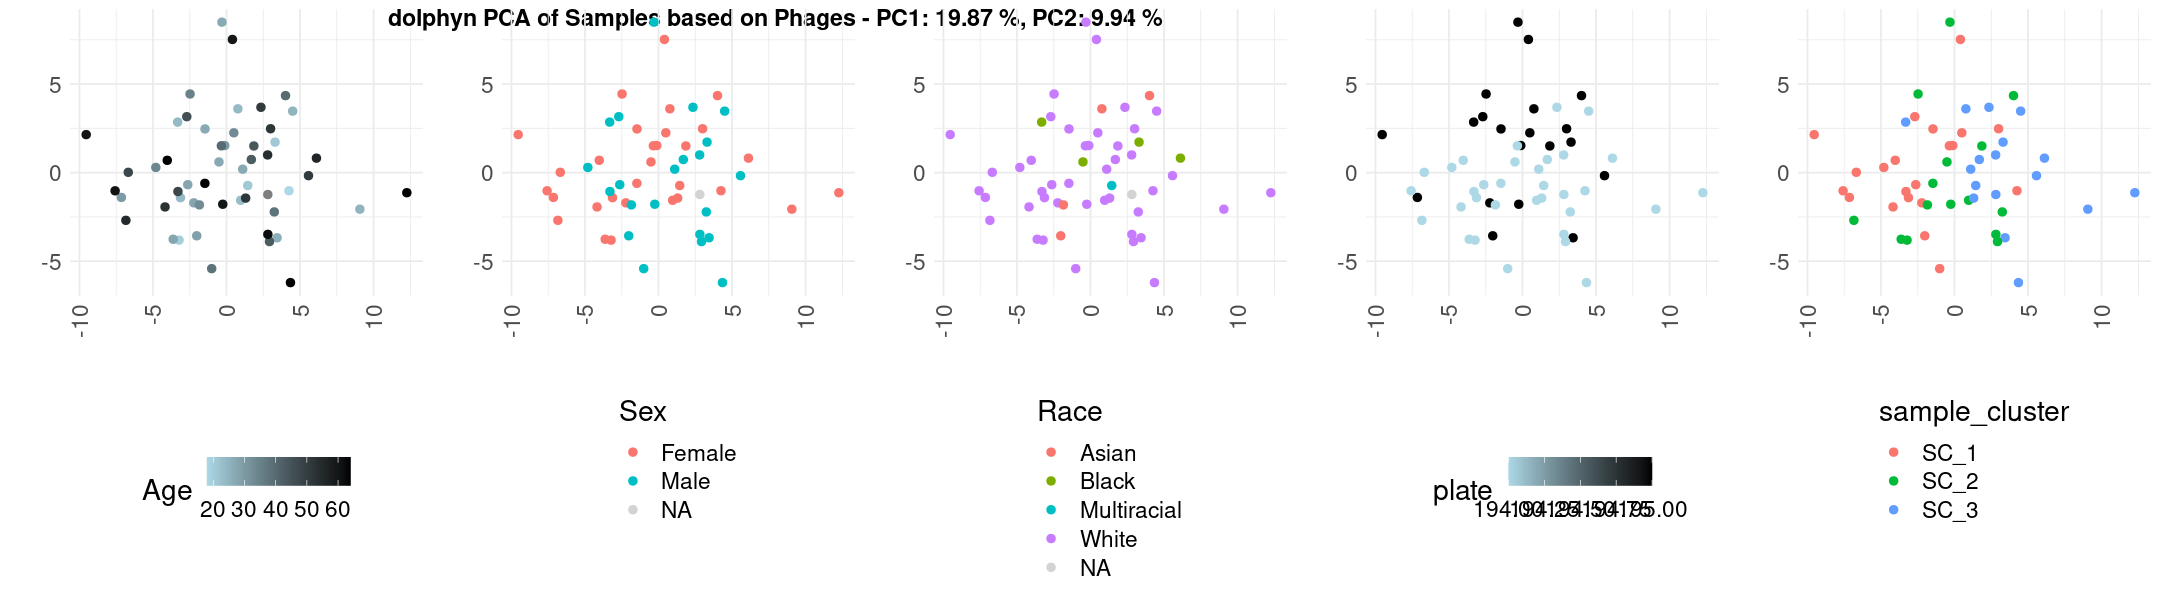

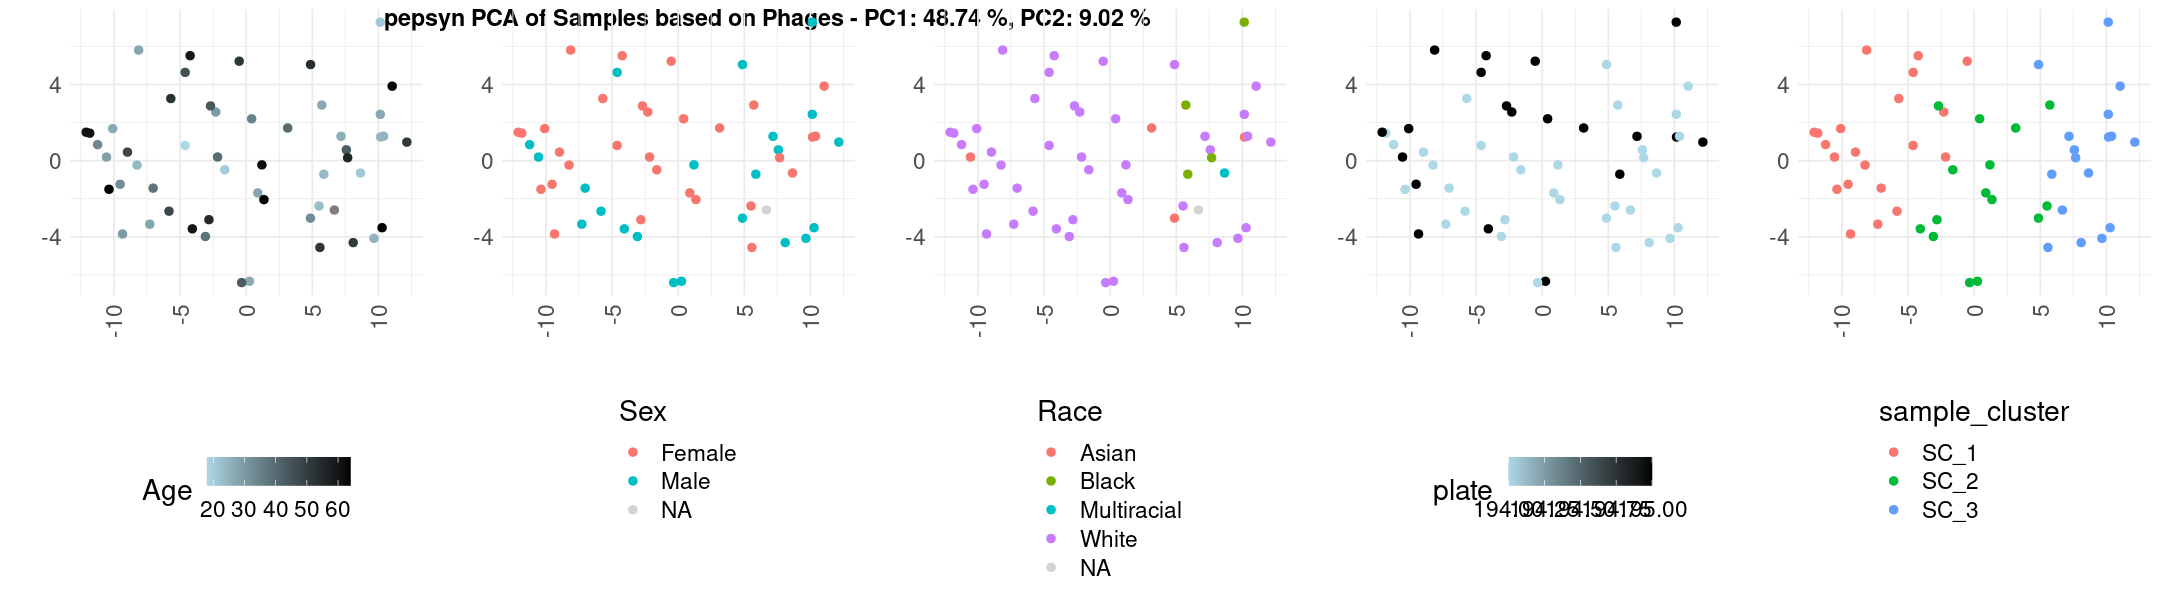

In [11]:
cols_of_interest = c("Age","Sex","Race", "plate", "sample_cluster")
score = "vir_score"

my_pca_function(cols_of_interest, "dolphyn", plots_horizontal = 5, score, switch_phages = TRUE, plotwid=18, plothei=5)
my_pca_function(cols_of_interest, "pepsyn", plots_horizontal = 5, score, switch_phages = TRUE, plotwid=18, plothei=5)

In [12]:
phar %>% select(taxon_id, sample, library, vir_score, vir_score_bin, NorthAmcaFreq, total_peps) %>% 
group_by(taxon_id, library, NorthAmcaFreq, total_peps) %>% summarise_at(vars(vir_score_bin),list(samples_reactive = sum)) %>%
mutate(library = factor(library, levels=c("pepsyn","dolphyn"))) -> temp
temp %>%
dcast(taxon_id + NorthAmcaFreq ~ library, value.var = "samples_reactive") %>%
subset(!is.na(dolphyn)) %>%
melt(id.vars = c("taxon_id","NorthAmcaFreq"), value.name = "samples_reactive", variable.name = "library") %>%
merge(temp) -> df

blank_dol = data.frame(NorthAmcaFreq = 50:630, total_peps = mean(df[df$library=="dolphyn",]$total_peps))
blank_pep = data.frame(NorthAmcaFreq = 50:630, total_peps = mean(df[df$library=="pepsyn",]$total_peps))
df %>% subset(library == "dolphyn") %>% glm(samples_reactive ~ NorthAmcaFreq + total_peps, data = .) %>%
predict(newdata = blank_dol) %>% cbind(blank_dol) %>% rename(samples_reactive = ".") %>% mutate(library = "dolphyn") -> lm_dol 
df %>% subset(library == "pepsyn") %>% glm(samples_reactive ~ NorthAmcaFreq + total_peps, data = .) %>%
predict(newdata = blank_pep) %>% cbind(blank_pep) %>% rename(samples_reactive = ".") %>% mutate(library = "pepsyn") %>% rbind(lm_dol) -> blank

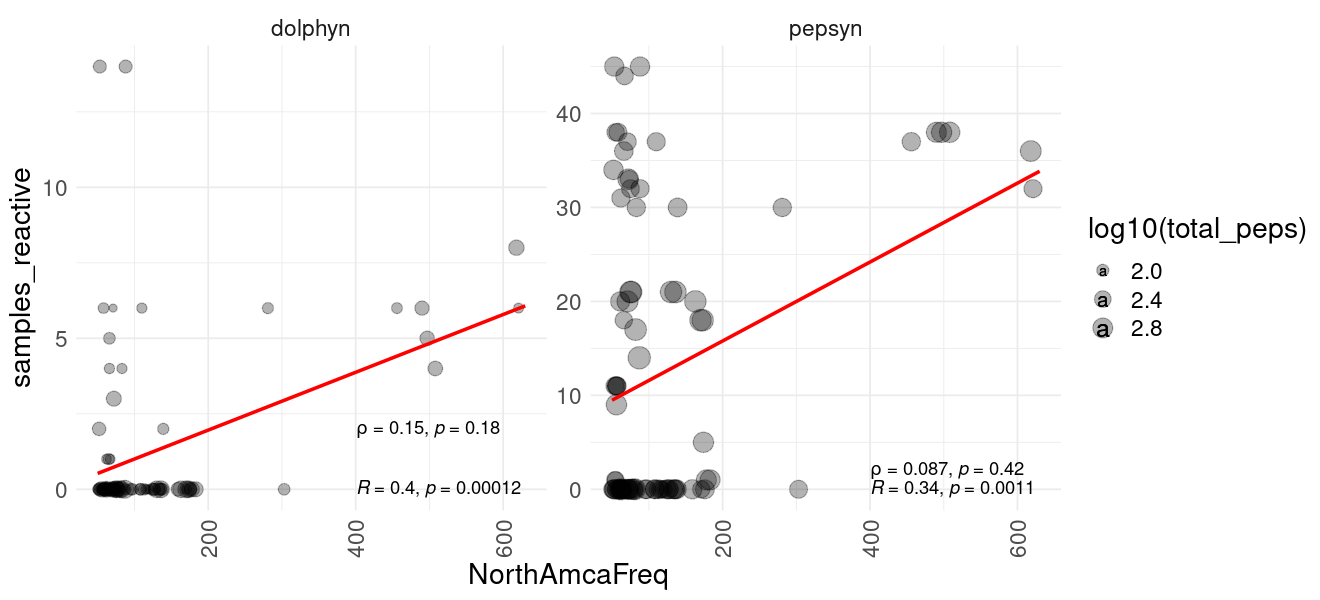

In [16]:
options(repr.plot.width=11, repr.plot.height=5)

phar %>% select(taxon_id, sample, library, vir_score, vir_score_bin, NorthAmcaFreq, total_peps) %>% 
group_by(taxon_id, library, NorthAmcaFreq, total_peps) %>% summarise_at(vars(vir_score_bin),list(samples_reactive = sum)) %>%
mutate(library = factor(library, levels=c("pepsyn","dolphyn"))) -> temp
temp %>%
dcast(taxon_id + NorthAmcaFreq ~ library, value.var = "samples_reactive") %>%
subset(!is.na(dolphyn)) %>% 
melt(id.vars = c("taxon_id","NorthAmcaFreq"), value.name = "samples_reactive", variable.name = "library") %>%
merge(temp) -> df

df %>% ggplot(aes(NorthAmcaFreq, samples_reactive, size = log10(total_peps))) + geom_point(alpha = 0.3) + 
geom_line(data = blank, size = 1, color = "red") + 
stat_cor(method = "pearson", label.x = 400, label.y = 0) + 
stat_cor(method = "spearman", label.x = 400, label.y = 2, cor.coef.name = "rho") + 
facet_wrap(.~library, scales="free")

In [ ]:
df %>% subset(library == "dolphyn") %>% glm(samples_reactive ~ NorthAmcaFreq + total_peps, data = .) %>% summary

In [ ]:
df %>% subset(library == "pepsyn") %>% glm(samples_reactive ~ NorthAmcaFreq + total_peps, data = .) %>% summary

In [ ]:
phar %>% subset(library == "pepsyn") %>% subset(! taxon_id %in% c("uvig_250342","uvig_358797","uvig_205260")) %>% 
group_by(taxon_id) %>% 
summarise_at(vars(vir_score), list(mean = mean, sum = sum, max = max)) %>%
arrange(desc(max)) %>% select(taxon_id) %>% unique %>% head(4) %>% unlist -> top_score_phage

phar %>% subset(library == "pepsyn") %>% 
group_by(sample) %>% 
summarise_at(vars(vir_score), list(mean = mean, sum = sum, max = max)) %>%
arrange(desc(max)) %>% head(5) %>% select(sample) %>% unique -> top_score_sample
top_score_sample[[1]] -> top_score_sample

In [ ]:
top_score_sample

In [ ]:
top_score_phage

In [ ]:
lfc_org = read.table("../data/PhageScan_peptide_logHFC.csv", sep = ",")
lfc_org %>% select(all_of(top_score_sample)) -> lfc
lfc %>% rownames_to_column("tile_id") %>% 
melt(id.vars = "tile_id", value.name="lfc", variable.name = "sample") -> psl

anno_pep = read.table("../data/PhageScan_PeptideAnno.tsv", header = TRUE, sep = "\t", stringsAsFactors=FALSE)

anno_pep %>% select(c("sublibrary", "pro_id", "tile_id", "taxon_id", "pro_id_all")) %>% 
rename(library = sublibrary) %>% merge(psl) -> psl 

psl %>% select(tile_id,pro_id_all) %>% distinct() %>% 
    mutate(pro_id_all = gsub("[{} ]","",pro_id_all)) %>%
    mutate(pro_id_all = strsplit(pro_id_all,",")) -> protein_clusters_map
p = protein_clusters_map$pro_id_all
names(p) <- protein_clusters_map$tile_id
stack(p) %>% mutate(values = gsub("'","",values)) -> protein_clusters

psl %>% merge(protein_clusters, by.x = 'tile_id', by.y = "ind", all = TRUE) %>% 
rename(pro_id_representative = pro_id) %>% rename(pro_id = values) %>% select(-pro_id_all, -tile_id) -> psl
psl %>% select(-taxon_id) %>%  mutate(taxon_id = sub("_[^_]+$", "", pro_id)) -> psl

psl %>% group_by(sample,library) %>%
mutate(lfc = lfc/(abs(max(lfc)))) %>% # normalizing reactivity for each sample to max 1, also normaized per library
mutate(lfc = ifelse(lfc<0,0,lfc)) %>% # truncatimg values to 0 (that were fc <1)
mutate(pep_bin = ifelse(lfc==0,0,1)) -> psl

In [ ]:
options(repr.plot.width=20, repr.plot.height=6)

psl %>% subset(library %in% c("dolphyn","pepsyn")) %>% 
subset(taxon_id %in% top_score_phage) %>%
group_by(pro_id, taxon_id, pro_id_representative, sample, library) %>% 
summarise_at(vars(lfc, pep_bin), list(sum = sum, n = length)) %>%
merge(GPD_anno %>% select(taxon_id,GPD_VC)) %>% arrange(taxon_id, desc(lfc_n)) %>%
distinct(pro_id_representative,sample,library,taxon_id, .keep_all = TRUE) %>% #removing proteins that are identical on the same phage
mutate(pro_id_representative = factor(pro_id_representative, levels = unique(pro_id_representative))) %>%
mutate(pro_id = factor(pro_id, levels = unique(pro_id))) %>%
mutate(taxon_id = factor(taxon_id, levels = unique(taxon_id))) -> df

df %>% ggplot(aes(pro_id, library)) + geom_tile(aes(fill = taxon_id, alpha = pep_bin_sum)) + 
  theme(axis.text.x=element_blank(), panel.grid.major.x = element_blank(), panel.grid.major.y = element_blank()) + facet_grid(sample~.)

In [ ]:
options(repr.plot.width=22, repr.plot.height=5)

set.seed(12)
phar %>% select(taxon_id) %>% unique %>% sample_n(12) %>% unlist -> random_phage_set

lfc_org %>% select('S3.0144.01X194') -> lfc
lfc %>% rownames_to_column("tile_id") %>% 
melt(id.vars = "tile_id", value.name="lfc", variable.name = "sample") -> psl

anno_pep %>% select(c("sublibrary", "pro_id", "tile_id", "taxon_id", "pro_id_all")) %>% 
rename(library = sublibrary) %>% merge(psl) -> psl 

psl %>% merge(protein_clusters, by.x = 'tile_id', by.y = "ind", all = TRUE) %>% 
rename(pro_id_representative = pro_id) %>% rename(pro_id = values) %>% select(-pro_id_all, -tile_id) %>% 
select(-taxon_id) %>%  mutate(taxon_id = sub("_[^_]+$", "", pro_id)) %>% 
group_by(sample,library) %>% subset(library %in% c("dolphyn","pepsyn")) %>% 
subset(taxon_id %in% random_phage_set) -> psl 

merge(psl, 
      psl %>% ungroup %>% subset(library == "pepsyn") %>% select(pro_id_representative, taxon_id) %>% 
      unique() %>% select(pro_id_representative) %>% table() %>% as.data.frame() %>% 
      rename(pro_id_representative = ".") %>% rename(in_phages = "Freq")) %>%
group_by(pro_id, taxon_id, pro_id_representative, sample, library, in_phages) %>% 
summarise_at(vars(lfc), list(n = length)) %>%
merge(GPD_anno %>% select(taxon_id,GPD_VC)) %>% arrange(taxon_id, desc(n), desc(in_phages),) %>%
distinct(pro_id_representative,sample,library,taxon_id, .keep_all = TRUE) %>%
mutate(pro_id_representative = factor(pro_id_representative, levels = unique(pro_id_representative))) %>%
mutate(taxon_id = factor(taxon_id, levels = unique(taxon_id))) %>%

ggplot(aes(pro_id_representative,taxon_id)) + geom_tile(aes(fill = log(n))) + scale_fill_gradient(low = "red", high = "black") + 
  theme(axis.text.x=element_blank(), axis.text.y=element_blank(), panel.grid.major.y = element_blank()) + facet_grid(library~.)
